In [1]:
## notebook setup
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/homes/sep/haipeng/develop/SWIT-1.0/toolbox-dev/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import HTML
#matplotlib.use('Qt5Agg')   # 'agg'

from acquisition import Model, Source, Receiver, Config
from solver import Solver
from optimizer import Optimizer
from preprocessor import Preprocessor

from utils import source_wavelet
from tools import load_float


In [3]:
work_path = '/scr2/haipeng/SWIT-1.1/01_fwi/'   # Working path
mpi_num   = 24                                     # MPI process for fd2dmpi

### model setup
nx,  nz, pml = [481,  141, 40]                     # Grid number along x and z directions, Grid number for PML layers (use a large one)
dx,  dt,  nt = [25, 0.002, 2001]                   # Grid size, time interval, and time step

# velocity and density
vp_true = np.zeros((nx, nz))
vp_init = np.zeros((nx, nz))
rho_true = np.zeros((nx, nz))
rho_init = np.zeros((nx, nz))

# true model
modelpath = '/homes/sep/haipeng/develop/SWIT-1.0/examples/case-01-marmousi2/model/'
# vp_true = np.loadtxt(modelpath + 'Marmousi_481_141_25m.dat')
# rho_true = np.power(vp_true, 0.25) * 310   # density models, (Gardner, 1974)

vp_true = np.ones((nx, nz)) * 4000
vp_true[220:240,60:80] = 4500
rho_true = np.power(vp_true, 0.25) * 310   # density models, (Gardner, 1974)
acquisition_type = 'land'

### sources setup 
f0    = 5.0                                              # Dominant frequency in Hz
amp0  = 1.0                                              # Amplitude of the source wavelet
srcxz = np.loadtxt(modelpath + 'source_coordinate.dat')  # Source coordinates
srcxz = srcxz[1:-1:2,:]
srcn  = srcxz.shape[0]                                   # Source number along x axis
wavelet  = np.zeros((srcn, nt))                          # Source wavelet

src = source_wavelet(amp0, nt, dt, f0, 'Ricker')

for isrc in range(srcn):
    wavelet[isrc,:] = source_wavelet(amp0, nt, dt, f0, 'ricker')

### receivers setup
temp = np.loadtxt(modelpath + 'receiver_coordinate.dat') # Receiver coordinates
recn = temp.shape[0]                                    # Receiver number
recxz = []                                              # Receiver positions
for isrc in range(srcn):
    # nrec = isrc * 10 + 1 
    # recxz_isrc = np.zeros((nrec, 2)) 
    # recxz_isrc[:,0] = temp[0:nrec,0]                          # Receiver x position (m)
    # recxz_isrc[:,1] = temp[0:nrec,1]                          # Receiver z position (m)
    # recxz.append(recxz_isrc) 
    nrec = nx 
    recxz_isrc = np.zeros((nrec, 2)) 
    recxz_isrc[:,0] = temp[0:nrec,0]                          # Receiver x position (m)
    recxz_isrc[:,1] = (nz-5) * dx - temp[0:nrec,1]                          # Receiver z position (m)
    recxz.append(recxz_isrc) 
    
# initial model
vp_init = np.ones((nx, nz)) * 4000
rho_init = np.power(vp_init, 0.25) * 310

In [4]:
## configuration
config = Config(work_path, mpi_num)

## model
model = Model(nx, nz, dx, dt, nt, pml, vp_true, rho_true, acquisition_type = acquisition_type)

## source
source = Source(srcxz, wavelet, f0)

## receiver 
receiver = Receiver(recxz, ['p'])

## solver
solver = Solver(config, model, source, receiver)

## optimizer
optimizer = Optimizer(vp_init = vp_init, rho_init = rho_init, 
                misfit_type = 'waveform', method = 'LBFGS', niter_max = 2,
                bound = False, vp_max = 5000, vp_min = 1000, update_vpmax = 50, 
                grad_smooth_size = 0, grad_mask = None, debug = False)

preprocessor = Preprocessor(filter_data = 'none', filter_low = 5.0, filter_high = 10.0, 
                 mute_late_arrival = True, mute_late_size = 0.5, 
                 normalize_data = False,
                 mute_near_offset = True, mute_near_distance = 500, 
                 mute_far_offset = True, mute_far_distance = 8000)


Solver information:
    Recording time    : nt = 2001, dt = 2.0 ms, total time = 4.0 s
    Model size        : nx = 481, nz = 141, dx = 25 m
    Model length      : 0 ~ 12.0 km
    Model depth       : 0 ~  3.5 km
    Model vp range    : 4000.0 ~ 4500.0 m/s
    Recording time    : nt = 2001, dt = 2.0 ms, total time = 4.0 s
    Source number     : 24, locating from 250.0 to 11750.0 m.
    Receiver type     : ['p']
    MPI task info     : 24 sources run in parallel

Optimizer information:
    Misfit function   : waveform
    Inversion method  : LBFGS
    Maximum iter      : 2
    Maximum update    : 50 m/s
    Maximum vp bound  : 5000.00 m/s
    Minimum vp bound  : 1000.00 m/s
    Initial vp model  : 4000.00 ~ 4000.00 m/s
    Gradient smooth   : 0 grids Gaussian smooth
    Gradient mask     : by default, 10 grids on top
    Debug option      : False

Preprocessor information:
    Filter data       : none
    Lowcut frequency  : 5.0 Hz
    Highcut frequency : 10.0 Hz
    Mute late arrival

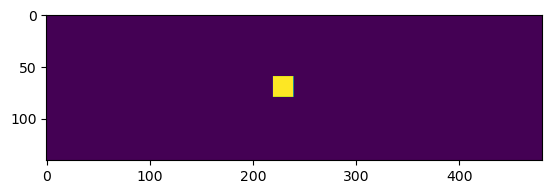

In [5]:
# run forward modeling to generate obs data
plt.imshow(vp_true.T)
solver.run(simu_type = 'forward', simu_tag = 'obs', data_format= 'su')

In [6]:
from workflow import FWI
fwi = FWI(solver, optimizer, preprocessor)



FWI workflow: directories are built and previous results are cleaned up if any.
FWI workflow: observed data are all found in: /scr2/haipeng/SWIT-1.1/01_fwi/data/obs/
FWI workflow: start iteration ...



In [7]:
fwi.run()

Iteration: 0 	 fcost: 3.7804e-07 	 step: 1.0000 	
Iteration: 1 	 fcost: 2.2500e-07 	 step: 1.0000 	
FWI workflow is finished.
FWI workflow runs for 00h 01m 1.23s
See the convergence history in iterate_LBFGS.log


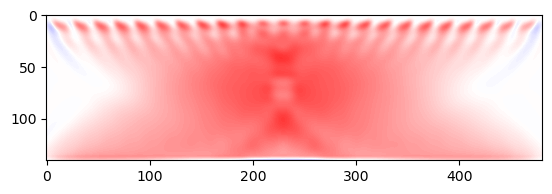

In [51]:
plt.imshow(grad.T, cmap='seismic', vmin=-1000, vmax=1000)

In [27]:
sg_obs = load_float('/scr2/haipeng/SWIT-1.1/01_fwi/data/obs/src12/sg_processed.bin').reshape(-1, nt)

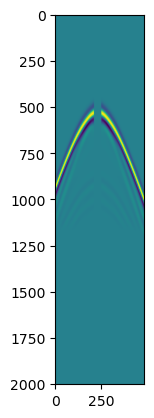

In [28]:
plt.imshow(sg_obs.T)

In [ ]:
# grad = np.zeros((nx, nz))
# for i in range(srcn):
#     grad += load_float(config.path + 'data/syn/src{}/vp_gradient.bin'.format(i+1)).reshape(nx, nz)
# grad = grad/grad.max()
# plt.imshow(grad.T, vmin = -0.6, vmax = 0.6)

In [84]:
path = '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/config.yaml'

In [85]:
par = load_yaml(path)

In [86]:
par

{'Config': {'path': '/scr2/haipeng/SWIT-1.1/01_fwi/',
  'job_type': 'fwi',
  'cpu_max_num': 48,
  'mpi_num': 40,
  'fig_aspect': 1.0},
 'Model': {'dt': 0.002,
  'dx': 25,
  'nt': 2001,
  'nx': 481,
  'nz': 141,
  'pml': 40,
  'acquisition_type': 'land',
  'vp_true': '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/acquisition/vp_true.npy',
  'rho_true': '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/acquisition/rho_true.npy'},
 'Receiver': {'comp': 'p',
  'coord_file': '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/acquisition/rec_coord.npz'},
 'Source': {'amp0': 1.0,
  'f0': 5.0,
  'type': 'ricker',
  'coord_file': '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/acquisition/src_coord.npy',
  'wavelet_file': '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/acquisition/wavelets.npy'},
 'Optimizer': {'vp_init': '/homes/sep/haipeng/develop/SWIT-1.0/examples-dev/case-01-Marmousi2/acquisition